# Homework 1: Calibrate My Camera

## Submission Deadline: Oct 7, 11:59PM

### This assignment is to be submitted individually.

This assignment is adapted from CMSC733 from University of Maryland, College Park.
***

# Introduction:

Estimating parameters of the camera like the focal length, distortion coefficients and principle point is called Camera Calibration. It is one of the most time consuming and important part of any computer vision research involving 3D geometry. An automatic way to perform efficient and robust camera calibration would be wonderful. One such method was presented Zhengyou Zhang of Microsoft in [this paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf) and is regarded as one of the hallmark papers in camera calibration. Recall that the camera calibration matrix K is given as follows:


$$ K = \begin{bmatrix} f_x & 0 & c_x \\
0 & f_y & c_y\\
0 & 0 & 1
\end{bmatrix}
$$

and radial distortion parameters are denoted by $k_1$ and $k_2$ respectively.




***

# Task:

A. The task is to estimate $f_x$, $f_y$, $c_x$, $c_y$, $k_1$ and $k_2$.

B. Submit the LaTeX $\texttt{report.pdf}$ in IEEE Tran/Conf format and Google colab output PDF + link to your Google colab.

C. Include the following in the submission report:

1. A $3\times3$ Calibration (K) Matrix
2. Distortion coefficients $k_1$ and $k_2$
3. K (After Non-Linear Minimization)
4. Reprojection Error
5. All the images of Checkerboard after rectification and reprojection of corners on rectified images.

#### Note: You are free to use functions such as $\texttt{cv2.findChessboardCorners}$ or any function that computes homography/perspective transformation. Alternatively, you are allowed to utilize any in-built function that you have already implemented in Project 1.
***

# Data:

The Zhang’s paper relies on a calibration target (checkerboard in our case) to estimate camera intrinsic parameters. The calibration target used can be found in the file [checkerboardPattern.pdf](https://github.com/cmsc733/cmsc733.github.io/raw/master/assets/2019/hw1/checkerboardPattern.pdf) Link. This was printed on an A4 paper and the size of each square was 21.5mm. Note that the Y axis has odd number of squares and X axis has even number of squares. It is a general practice to neglect the outer squares (extreme square on each side and in both directions). Thirteen images taken from a Google Pixel XL phone with focus locked can be downloaded from [here](https://github.com/cmsc733/cmsc733.github.io/raw/master/assets/2019/hw1/Calibration_Imgs.zip) or [here](https://drive.google.com/drive/folders/1-4oP9__FvpmysDwEqFzXfqKv6WJtNPx1) which you will use to calibrate.
***

# Initial Parameters Estimation:

We are trying to get a good initial estimate of the parameters so that we can feed it into the non-linear optimizer. We will define the parameters we are using in the code next.

$x$ denotes the image points, $X$ denotes the world points (points on the checkerboard), $k_s$ denotes the radial distortion parameters, $K$ denotes the camera calibration matrix, $R$ and $t$ represent the rotation matrix and the translation of the camera in the world frame.
<br>

### A. Solve for approximate $K$ or camera intrinsic matrix: [40pt]

Refer to Section 3.1 in [this paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf) for a solution of parameters in K. Use cv2.findChessboardCorners function in OpenCV to find the corners of the Checker board with appropriate parameters here.


### B. Estimate approximate $R$ and $t$ or camera extrinsics: [20pt]

Refer to Section 3.1 in the same Zhang's paper for details on how to estimate $R$ and $t$. Note that the author mentions a method to convert a normal matrix to a rotation matrix in Appendix C, this can be neglected most of the times.

### C. Approximate Distortion $k_s$: [20pt]

Because we assumed that the camera has minimal distortion we can assume that $k_s=[0,0]^T$ for a good initial estimate.
<br><br>


<br>

# Non-Linear Geometric Error Minimization: [10pt]

We have the initial estimates of $K,R,t,k_s$, now we want to minimize the geometric error defined as given below

$$∑_{i=1}^N ∑_{j=1}^M||x_{i,j}−\hat{x}_{i,j} (K,R_i,t_i,X_j,k_s)||$$


Here $x_{i,j}$ and $\hat{x}_{i,j}$ are an inhomogeneous representation. Feel free to use $\texttt{scipy.optimize}$ to minimize the loss function described above. Refer to Section 3.3 in the same Zhang's paper for a detailed explanation of the distortion model, you’ll need this part for the minimization function.
<br>

# Plot Undistorted Images [10pt]

<hr>

# Step 1: Load all the input images and define save folder where you will save the undistorted images


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

def load_images_from_directory(directory):
    file_list = os.listdir(directory)
    image_files = [file for file in file_list if file.endswith(".jpeg")]
    images = []
    filenames = []

    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        img = cv2.imread(image_path)

        if img is not None:
            images.append(img)
            filenames.append(image_file)
        else:
            print(f"Error loading image: {image_file}")

    return images, filenames

def save_image_to_directory(image, output_directory, filename):
    os.makedirs(output_directory, exist_ok=True)
    save_path = os.path.join(output_directory, filename)

    cv2.imwrite(save_path, image)
    print(f"Saved image: {save_path}")

# file_list = os.listdir("./checkerboard")
# image_files = [file for file in file_list if file.endswith(".jpeg")]
# for image_file in image_files:
#     image_path = os.path.join("./checkerboard",image_file)
#     img = cv2.imread(image_path)
#     plt.imshow(img)
#     plt.show()

# Step 2: Get all Corners
It is a good practice to ignore the corners on the edges of the checkerboard (not required though).
In this step, write a function $\texttt{get_corners}$:

In [ ]:
def get_corners(images, Nx, Ny):
    corner_list = []
    corner_status_list = []
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


        ret, corners = cv2.findChessboardCorners(gray, (Nx, Ny), None)

        if ret:
            # Refine corners
            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            corner_list.append(corners.reshape(-1, 2))
            corner_status_list.append(True)
        else:

            corner_list.append(None)
            corner_status_list.append(False)

    return corner_list, corner_status_list

In [ ]:
# l,s= get_corners(image_files,9,6)

# Step 3: Get Homographies

In [ ]:
import numpy as np
import cv2

def get_homographies(corner_list, Nx, Ny, SquareSize=21.5):
    """
    Computes homography matrices for multiple images using detected corners and chessboard world coordinates.

    Args:
    - corner_list: List of detected corner points (Nx1x2 arrays) for each image where detection was successful.
    - Nx: The number of inner corners along the x-axis of the checkerboard pattern.
    - Ny: The number of inner corners along the y-axis of the checkerboard pattern.
    - SquareSize: Size of each square on the checkerboard in millimeters (real-world units).

    Returns:
    - H_list: List of 3x3 homography matrices, where each matrix represents a transformation
              between world points and their corresponding image points for each scene.
    - Pw: A grid of points representing the real-world 2D coordinates of the checkerboard corners (Nx * Ny, 2).
    """

    Pw = np.zeros((Nx * Ny, 2), dtype=np.float32)
    for i in range(Ny):
        for j in range(Nx):
            Pw[i * Nx + j] = [j * SquareSize, i * SquareSize]


    H_list = []  # List to store homographies

    # Loop through each set of detected corners in the images
    for Pc in corner_list:
        if Pc is not None:


            # Compute the homography using cv2.findHomography
            H, _ = cv2.findHomography(Pw, Pc, cv2.RANSAC)

            if H is not None:
                # Append the homography matrix to the list
                H_list.append(H)
            else:
                print("No homography")

    return H_list, Pw


In [ ]:
# H_list,Pw = get_homographies(l,9,6)

# Step 4: Closed-Form Solution: Estimate B Matrix using Homography
(As given in Zhang's calibration paper - Sec 3.1)

In [ ]:
import numpy as np

def get_B(H_list):
    """
    Input:
    H_list : List
        A list of 3x3 homography matrices, where each matrix represents a transformation
        between world points and their corresponding image points for a specific scene.

    Output:
    B : ndarray
        A 3x3 symmetric matrix, which encodes the intrinsic camera parameters in a non-intuitive form.
        This matrix is used in the calculation of the camera's intrinsic parameters like focal lengths,
        skew, and principal points in subsequent steps.
    """

    def v(H, i, j):
        i,j = i-1,j-1
        return np.array([
            H[0, i] * H[0, j],
            H[0, i] * H[1, j] + H[1, i] * H[0, j],
            H[1, i] * H[1, j],
            H[2, i] * H[0, j] + H[0, i] * H[2, j],
            H[2, i] * H[1, j] + H[1, i] * H[2, j],
            H[2, i] * H[2, j]
        ])

    # Initialize a list to store the v(H) matrices
    V = []

    # Loop through each homography matrix in the list
    for H in H_list:
        v12 = v(H,1,2).T
        v11 = v(H,1,1)
        v22 = v(H,2,2)
        v11_v22 = (v11-v22).T
        V.append(v12)
        V.append(v11_v22)  # v(H, 1, 1) - v(H, 2, 2)

    V = np.array(V)

    _, _, vh = np.linalg.svd(V)
    b = vh[-1, :]


    B = np.array([
        [b[0], b[1], b[3]],
        [b[1], b[2], b[4]],
        [b[3], b[4], b[5]]
    ])

    return B


In [ ]:
# B= get_B(H_list)
# B

In [ ]:
# print("Matrix B:", B)
# print("B[0, 0]:", B[0, 0], "B[1, 1]:", B[1, 1], "B[2, 2]:", B[2, 2])

# Step 5: Estimate A (Or the initial Camera Calibration K Matrix) of the form:

    [  fx   s    u0 ]
    [  0    fy   v0 ]
    [  0     0    1 ]

In [ ]:
import numpy as np

def get_A(B):
    """
    Input:
      B : np.ndarray
          A 3x3 symmetric matrix derived from the homographies, encoding the intrinsic
          parameters of the camera in a non-intuitive form. This matrix is used to calculate
          the camera's intrinsic parameters like focal lengths, skew, and principal points.

    Output:
      A : np.ndarray
          A 3x3 intrinsic camera matrix containing the camera's internal parameters:
          - Focal lengths (fx, fy)
          - Principal point (u0, v0)
          - Skew (skew)

          The matrix has the form:
          [[fx, skew,  u0],
           [ 0,    fy,  v0],
           [ 0,     0,   1]]
    """

    # Compute the principal points (u0, v0) from B
    v0 = abs(B[1, 2] / B[1, 1])
    u0 = abs(B[0, 2] / B[0, 0])

    # Compute the scale factor

    scale = B[2, 2] - ((u0**2) * B[0, 0] + 2 * u0 * v0 * B[0, 1] + (v0**2) * B[1, 1])

    # Compute focal lengths ensuring positive values
    fx = np.sqrt(abs(scale / B[0, 0]))
    fy = np.sqrt(abs(scale / B[1, 1]))

    # Calculate the skew based on B and fx, fy
    skew = -B[0, 1] / np.sqrt(abs(B[0, 0] * B[1, 1]))

    # Construct the intrinsic matrix A
    A = np.array([[fx, skew, u0],
                  [0,  fy,   v0],
                  [0,  0,    1]])

    return A


In [ ]:
# A = get_A(B)
# A

# Step 6: Get Transformations from Initial K and Homographies

In [ ]:
import numpy as np

def get_all_transformations(A, H_list):
    """
    Input:
        A : np.ndarray
            The 3x3 intrinsic camera matrix, which contains the camera's internal parameters
            like focal lengths (fx, fy), skew (g), and the principal point (u0, v0).

        H_list : List[np.ndarray]
            A list of 3x3 homography matrices, where each matrix represents a transformation
            between world points and image points for a specific scene or image.

    Output:
        T_list : List[np.ndarray]
            A list of 3x4 transformation matrices, where each matrix contains the camera's
            rotation (r1, r2, r3) and translation (t) for a specific homography. Each transformation
            matrix maps world coordinates to camera coordinates.
    """

    # Compute the inverse of the intrinsic matrix A
    Ainv = np.linalg.inv(A)

    # Initialize a list to store the transformation matrices (rotation and translation)
    T_list = []

    # Loop through each homography matrix in the list
    for H in H_list:
        # Compute the scaling factor l
        # This normalizes the first column of the homography matrix when transformed by Ainv
        h1, h2, h3 = H[:, 0], H[:, 1], H[:, 2]
        lamda = 1 / np.linalg.norm(np.dot(Ainv, h1))  # Scaling factor

        # Compute the first and second rotation vectors (r1 and r2) from the homography matrix
            # First column of the homography matrix
            # Second column of the homography matrix
        r1 = lamda * np.dot(Ainv, h1)
        r2 = lamda * np.dot(Ainv, h2)
        # Compute the third rotation vector (r3) as the cross product of r1 and r2
        # This ensures that the rotation matrix remains orthogonal
        # Compute the translation vector t from the third column of the homography matrix
        r3 = np.cross(r1, r2)


        t = lamda * np.dot(Ainv, h3)

         # Stack the rotation vectors (r1, r2, r3) and the translation vector t horizontally
      # This forms a 3x4 transformation matrix combining both rotation and translation
        T = np.column_stack((r1, r2, r3, t))

        # Append the transformation matrix to the list
        T_list.append(T)

    # Return the list of transformation matrices
    return T_list


In [ ]:
# T_list = get_all_transformations(A,H_list)
# T_list

# Step 7: Compute Reprojection Error

In [ ]:
def get_reprojection_error(A, k1, k2, T_list, Pc_list, Pw):
    """
    Input:
    A : np.ndarray
        The 3x3 intrinsic camera matrix containing the camera's internal parameters (focal lengths, principal points, skew).

    k1 : float
        The first radial distortion coefficient. This corrects for lens distortion by adjusting the points based on the amount of radial distortion.

    k2 : float
        The second radial distortion coefficient. This is used for higher-order corrections of radial distortion.

    T_list : List
        A list of 3x4 transformation matrices (one for each image), each of which combines the camera's rotation and translation
        relative to the world scene.

    Pc_list : List
        A list of 2D points (image coordinates) detected in each image. Each item in the list corresponds to an image and contains
        the 2D image coordinates of the checkerboard corners or other known points.

    Pw : np.ndarray
        The 3D world coordinates (in real space) of the checkerboard corners or other known points used for calibration.
        This is a (N x 2) array, where N is the number of world points.

    Output:
    reproj_error : float
        The average reprojection error over all the images and points. This error quantifies the difference between the observed 2D points
        and the projected points from the 3D world points.

    RPc_list : List
        A list of reprojected 2D points. For each image, this is the result of projecting the world points (`Pw`) back onto the image plane
        using the intrinsic matrix `A` and the transformation matrices in `T_list`.
    """

    RPc_list = []  # List to store reprojected 2D points for each image
    reproj_error = 0  # Initialize total error

    # Loop through each set of 2D image points (Pc) and transformation matrix (T)
    for Pc, T in zip(Pc_list, T_list):
        # Compute the 3D homogeneous coordinates of the world points projected into the camera frame
        Pw_homogenenous = np.column_stack((Pw, np.zeros((Pw.shape[0], 1)), np.ones((Pw.shape[0], 1))))
        P_camera = T @ Pw_homogenenous.T

        # Normalize the projected 3D points by their third coordinate to convert them to 2D homogeneous coordinates
        P_camera /= P_camera[2, :]

        # Reproject the normalized points using the intrinsic matrix A
        P_reprojected_2d = A @ P_camera

        # Extract the 2D coordinates
        # Append the reprojected 2D points to the list
        x = P_reprojected_2d[0, :] / P_reprojected_2d[2, :]
        y = P_reprojected_2d[1, :] / P_reprojected_2d[2, :]
        Uhat = np.vstack((x, y)).T

        # Compute the radial distortion
        u0, v0 = A[0, 2], A[1, 2]
        r = np.sqrt((Uhat[:, 0] - u0)**2 + (Uhat[:, 1] - v0)**2)

        # Apply radial distortion
        rad_dist = 1 + k1 * r + k2 * r**2
        Uhat_distorted = np.zeros_like(Uhat)
        Uhat_distorted[:, 0] = Uhat[:, 0] + (Uhat[:, 0] - u0) * (rad_dist - 1)
        Uhat_distorted[:, 1] = Uhat[:, 1] + (Uhat[:, 1] - v0) * (rad_dist - 1)

        # Store the reprojected and distorted points
        RPc_list.append(Uhat_distorted)

        # Compute the reprojection error
        reprojection_errors = np.linalg.norm(Pc - Uhat_distorted, axis=1)**2
        reproj_error += np.sum(reprojection_errors)



    # Compute the average reprojection error by dividing the total error by the number of points and images
    reproj_error /= Pw.shape[0] * len(Pc_list)

    # Return the average reprojection error and the list of reprojected 2D points
    return reproj_error, RPc_list

# Step 8: Define Objective Function for Minimization

In [ ]:
def objective_function(x, T_list, Pc_list, Pw):
    A = np.array([[x[0], x[1], x[2]],  # fx, skew, u0
                  [0, x[3], x[4]],     # 0, fy, v0
                  [0, 0, 1]])          # homogeneous coordinate row

    k1 = x[5]
    k2 = x[6]

    reproj_error = 0

    # Loop through each set of 2D image points (Pc) and transformation matrix (T)
    for Pc, T in zip(Pc_list, T_list):

        Pw_homogeneous = np.column_stack((Pw, np.zeros((Pw.shape[0], 1)), np.ones((Pw.shape[0], 1))))
        P_camera = T @ Pw_homogeneous.T

        # Normalize the projected 3D points by their third coordinate to convert them to 2D homogeneous coordinates
        P_camera /= P_camera[2, :]

        # Reproject the normalized points using the intrinsic matrix A
        P_reprojected_2d = A @ P_camera

        x_proj = P_reprojected_2d[0, :] / P_reprojected_2d[2, :]
        y_proj = P_reprojected_2d[1, :] / P_reprojected_2d[2, :]
        Uhat = np.vstack((x_proj, y_proj)).T  # Reprojected points without distortion

        # Compute the radial distortion
        u0, v0 = A[0, 2], A[1, 2]
        r = np.sqrt((Uhat[:, 0] - u0)**2 + (Uhat[:, 1] - v0)**2)

        # Apply radial distortion
        rad_dist = 1 + k1 * r + k2 * r**2
        Uhat_distorted = np.zeros_like(Uhat)
        Uhat_distorted[:, 0] = Uhat[:, 0] + (Uhat[:, 0] - u0) * (rad_dist - 1)
        Uhat_distorted[:, 1] = Uhat[:, 1] + (Uhat[:, 1] - v0) * (rad_dist - 1)

        # Compute the reprojection error and accumulate it
        reprojection_errors = np.linalg.norm(Pc - Uhat_distorted, axis=1)**2
        reproj_error += np.sum(reprojection_errors)

    return reproj_error


# Step 9 and 10: Put Everything together, minimize and rectify images
(Feel free to use $\texttt{minimize}$ from $\texttt{scipy.optimize}$).



In [ ]:
import os
import cv2
import numpy as np
from scipy.optimize import minimize

Nx = 6
Ny = 9

def main():
    """
    Main function to perform camera calibration and reprojection error optimization.
    """
    # file_list = os.listdir("./checkerboard")
    # image_files = [file for file in file_list if file.endswith(".jpeg")]
    # for image_file in image_files:
    #     image_path = os.path.join("./checkerboard",image_file)
    #     img = cv2.imread(image_path)
    #     plt.imshow(img)
    #     plt.show()
    # img_dir = os.listdir("./checkerboard")
    # image_files = [file for file in img_dir if file.endswith(".jpeg")]
    # images = load_images_from_directory("checkerboard")

    # Step 1: Load input image path and create image path list
    directory = "/content/drive/MyDrive/Checkerboard"
    images, image_filenames = load_images_from_directory(directory)
    # file_list = os.listdir("./checkerboard")
    # img_path_list = [file for file in file_list if file.endswith(".jpeg")]
    # for image_file in img_path_list:
    #     image_path = os.path.join("./checkerboard",image_file)
    #     img = cv2.imread(image_path)  # Folder to save undistorted images
    # Get list of images from directory
    # img_path_list = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith('.jpeg')]
    # print(f"Number of images: {len(img_path_list)}")

    # Step 2: Detect corners in the images
    corner_list, corner_status_list = get_corners(images, Nx, Ny)
    # print(corner_list)
    # Step 3: Calculate homographies from detected corners
    H_list, Pw = get_homographies(corner_list, Nx, Ny)
    # print(H_list)
    # Step 4: Get B Matrix
    B = get_B(H_list)

    # Step 5: Compute initial intrinsic matrix (A)
    A_initial = get_A(B)
    print("Initial Calibration K Matrix: ", A_initial)
    print("\n")

    # Step 6: Calculate the transformations for each homography using the initial intrinsic matrix
    T_list = get_all_transformations(A_initial, H_list)

    # Step 7: Compute initial reprojection error with no distortion coefficients
    k1, k2 = 0, 0  # Initially no distortion coefficients
    reproj_error, RPc_list = get_reprojection_error(A_initial, k1, k2, T_list, corner_list, Pw)
    print("Initial Reprojection Error: ", reproj_error)
    print("\n")

    # Step 8: Use optimization techniques to minimize reprojection error and refine intrinsic matrix and distortion coefficients
    # Define the objective function for optimization

    # Initialize for the optimization (including the intrinsic parameters and distortion coefficients)
    x0 = np.array([A_initial[0, 0], A_initial[0, 1], A_initial[0, 2], A_initial[1, 1], A_initial[1, 2], 0, 0])

    # Optimize using Nelder-Mead method to minimize the reprojection error
    res = minimize(objective_function, x0, args=(T_list, corner_list, Pw), method='Nelder-Mead')

    # Extract optimized parameters
    x = res.x
    print(x)
    A_optimized = np.array([[x[0], x[1], x[2]], [0, x[3], x[4]], [0, 0, 1]])
    k1_optimized, k2_optimized = x[5], x[6]
    # k1_optimized,k2_optimized = 2.88970165e-01, -2.39883441e+00

    print("Optimized Calibration K Matrix :", A_optimized)
    print("\n")
    print("Optimized Distortion coefficients :", "\n")
    print("k1 : ", k1_optimized)
    print("k2 : ", k2_optimized)
    print("\n")

    # Step 9: Compute the final reprojection error after optimization
    final_error, RPc_list = get_reprojection_error(A_optimized, k1_optimized, k2_optimized, T_list, corner_list, Pw)
    print("Final reprojection error : ", final_error)


    # Step 10: Undistort and save each image with reprojected corners
    pic_num=0
    for img in images:
        # print(img)
        # img = cv2.imread(img[0])
        und_img = img.copy()

        undistorted_img = cv2.undistort(und_img, A_optimized,np.array([k1_optimized, k2_optimized, 0, 0, 0]))
        save_image_to_directory(undistorted_img, "output_undistort", str(pic_num)+".png")
        img_dup = undistorted_img.copy()
        ret,corners = cv2.findChessboardCorners(img_dup, (Nx, Ny))
        cv2.drawChessboardCorners(img_dup, (Nx, Ny), corners, ret)
        plt.imshow(cv2.cvtColor(img_dup, cv2.COLOR_BGR2RGB))
        os.makedirs('undistorted_corner_detected', exist_ok=True)
        plt.savefig(f'undistorted_corner_detected/result{pic_num}.png')
        plt.close()
        pic_num+=1
    # output_directory = "check"
    # os.makedirs(output_directory, exist_ok=True)

    # for image_file in img_path_list:
    #     image_path = os.path.join("./checkerboard", image_file)
    #     img = cv2.imread(image_path)

    #     undistorted_img = cv2.undistort(img, A_optimized,np.array([k1_optimized, k2_optimized, 0, 0, 0]))


    #     if undistorted_img is None or undistorted_img.size == 0:
    #         print(f"Error undistorting image: {image_path}")
    #         continue

    #     save_path = os.path.join(output_directory, os.path.basename(image_path))


    #     cv2.imwrite(save_path, undistorted_img)

    #     print(f"Saved undistorted image: {save_path}")  # Print the saved path for confirmation

        # Display the original and undistorted images side by side
        # plt.figure(figsize=(10, 5))


        # plt.subplot(1, 2, 1)
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # plt.axis('off')  # Turn off axis


        # plt.subplot(1, 2, 2)
        # plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
        # plt.title("Undistorted Image")
        # plt.axis('off')  # Turn off axis

        # plt.tight_layout()
        # plt.show()

if __name__ == "__main__":
    main()

Initial Calibration K Matrix:  [[ 2.04415525e+03 -8.02726546e-04  7.65306543e+02]
 [ 0.00000000e+00  2.03147015e+03  1.36504439e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Initial Reprojection Error:  0.8200869651967344


[ 2.03430471e+03 -7.76802380e-04  7.65277602e+02  2.02102933e+03
  1.36509861e+03  2.23599842e-05 -2.07607060e-08]
Optimized Calibration K Matrix : [[ 2.03430471e+03 -7.76802380e-04  7.65277602e+02]
 [ 0.00000000e+00  2.02102933e+03  1.36509861e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Optimized Distortion coefficients : 

k1 :  2.235998419222371e-05
k2 :  -2.0760706012935982e-08


Final reprojection error :  0.7210032893956126
Saved image: output_undistort\0.png
Saved image: output_undistort\1.png
Saved image: output_undistort\2.png
Saved image: output_undistort\3.png
Saved image: output_undistort\4.png
Saved image: output_undistort\5.png
Saved image: output_undistort\6.png
Saved image: output_undistort\7.png
Saved image: output_undist

Saved row image: output_rows\row_0.png


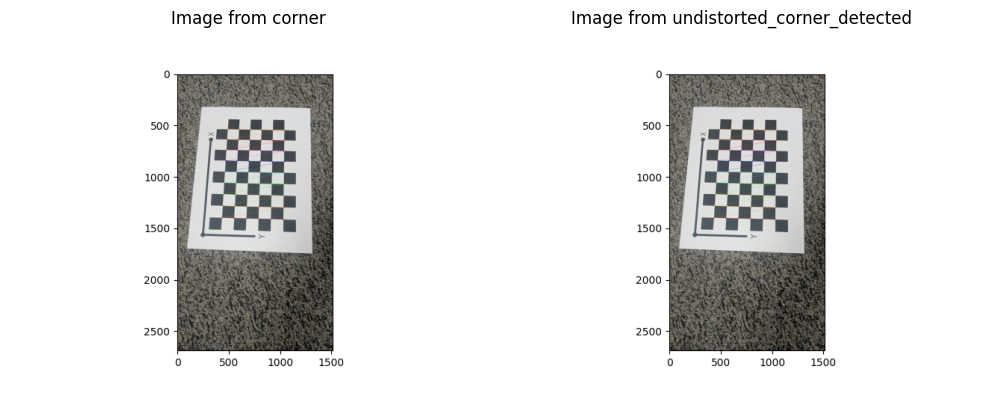

Saved row image: output_rows\row_1.png


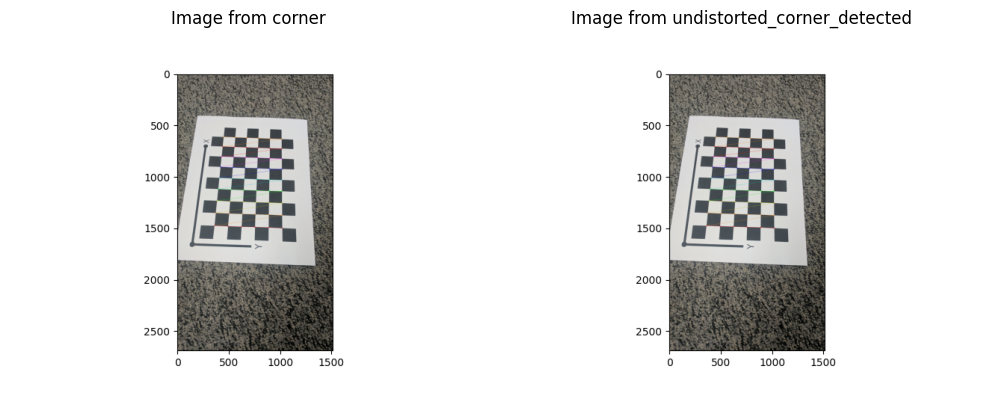

Saved row image: output_rows\row_2.png


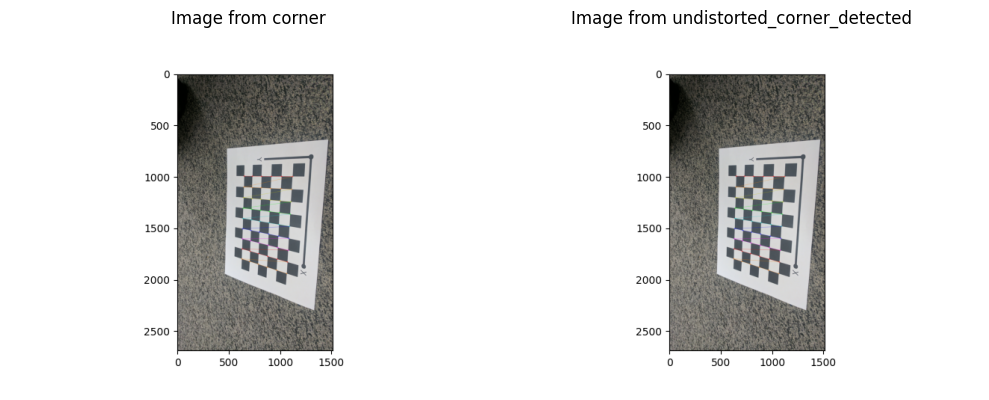

Saved row image: output_rows\row_3.png


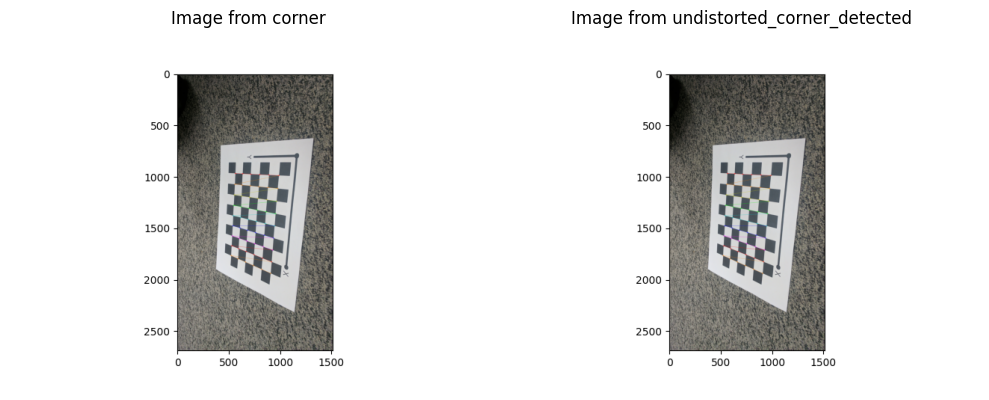

Saved row image: output_rows\row_4.png


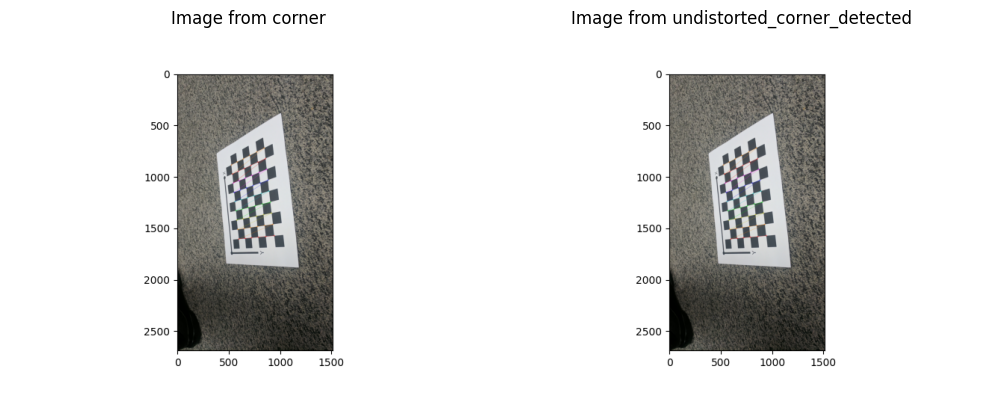

Saved row image: output_rows\row_5.png


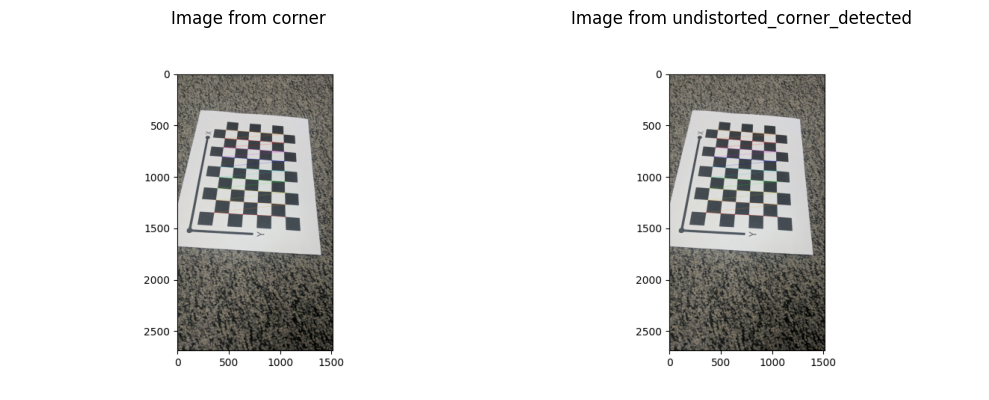

Saved row image: output_rows\row_6.png


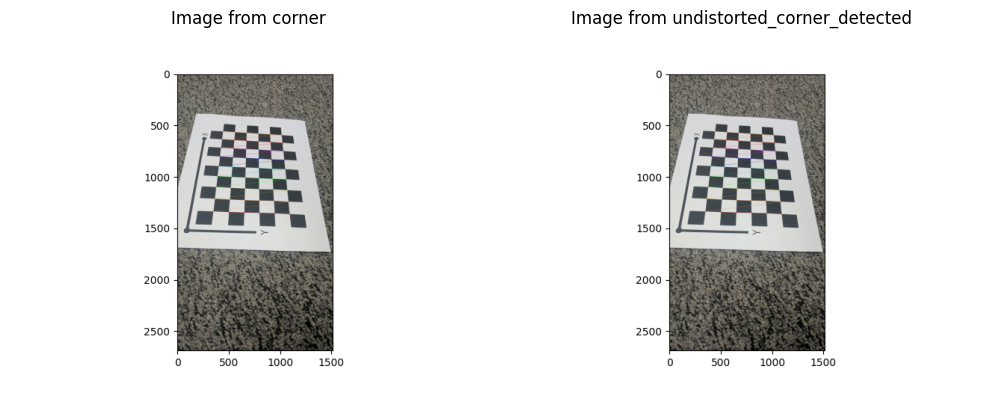

Saved row image: output_rows\row_7.png


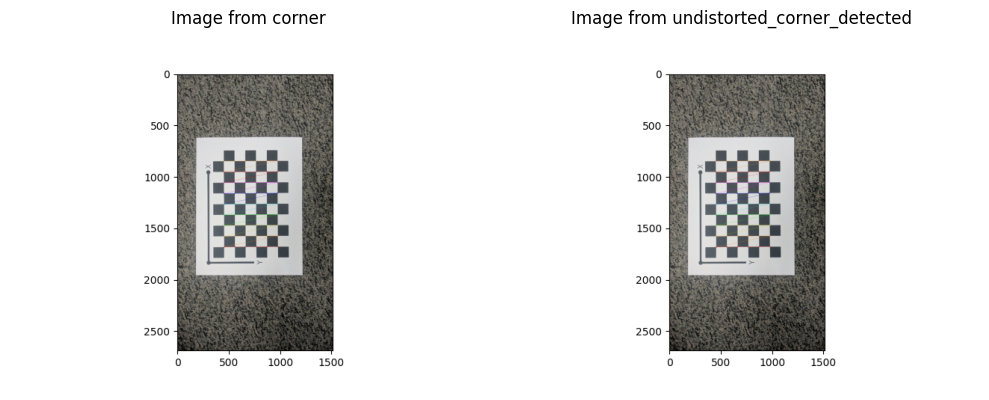

Saved row image: output_rows\row_8.png


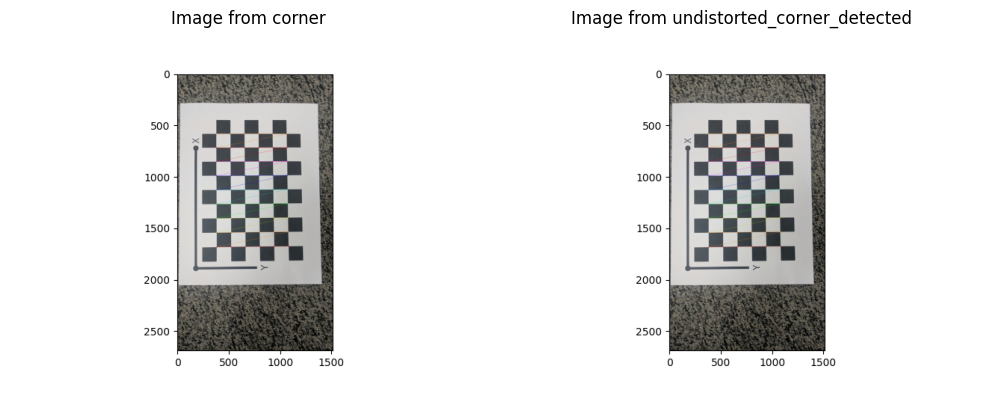

Saved row image: output_rows\row_9.png


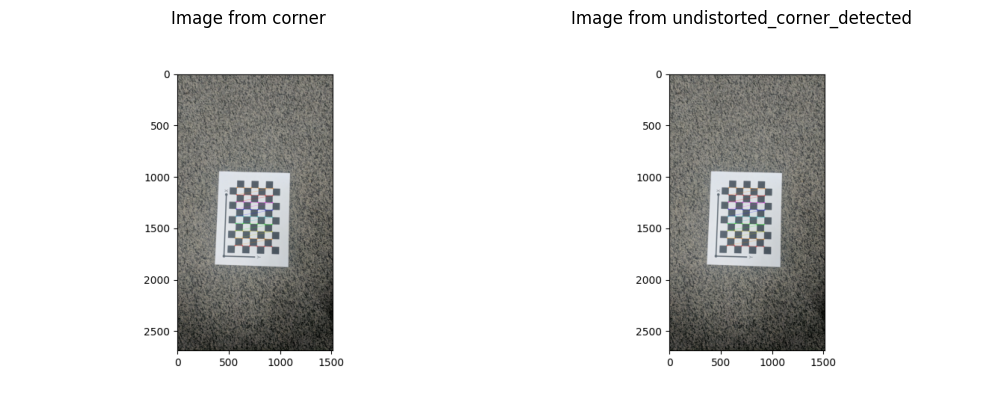

Saved row image: output_rows\row_10.png


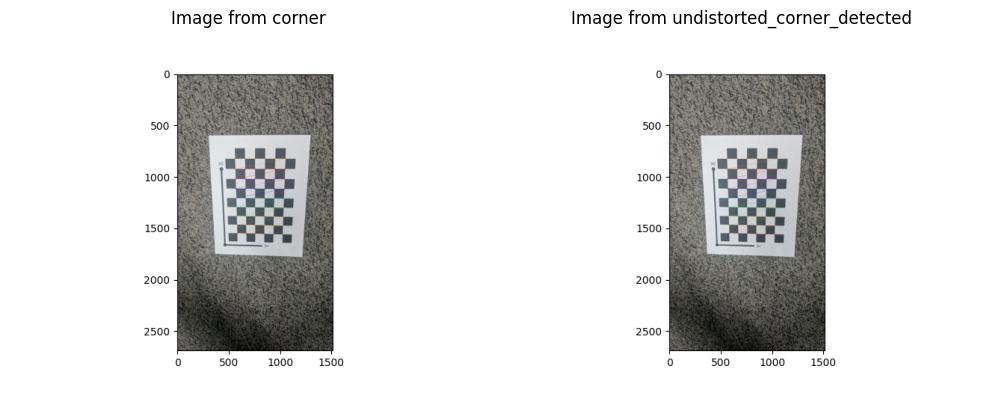

Saved row image: output_rows\row_11.png


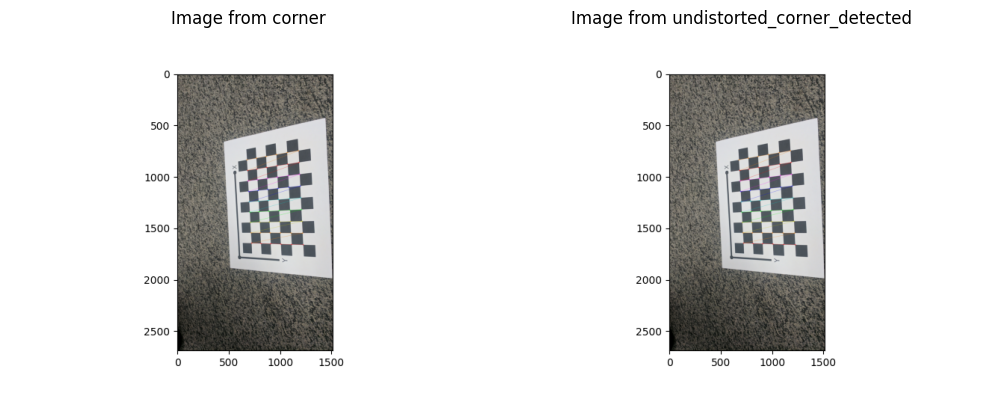

Saved row image: output_rows\row_12.png


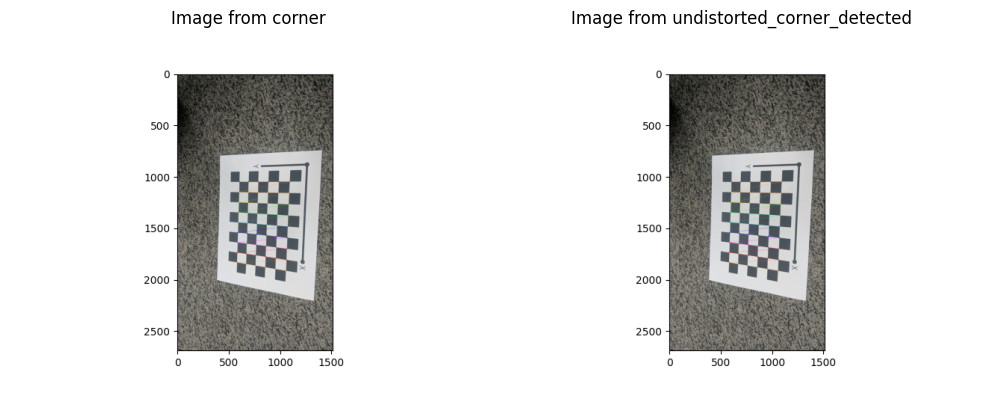

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images_side_by_side(dir1, dir2, output_dir="output_rows"):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # List image files in both directories
    images_dir1 = [file for file in os.listdir(dir1) if file.endswith(('.png', '.jpeg', '.jpg'))]
    images_dir2 = [file for file in os.listdir(dir2) if file.endswith(('.png', '.jpeg', '.jpg'))]

    # Check that the directories have the same number of images
    assert len(images_dir1) == len(images_dir2), "Both directories must have the same number of images."

    # Display each image pair separately, side by side in a new figure
    for i in range(len(images_dir1)):
        # Load images
        img_path1 = os.path.join(dir1, images_dir1[i])
        img_path2 = os.path.join(dir2, images_dir2[i])

        img1 = cv2.imread(img_path1)
        img2 = cv2.imread(img_path2)

        # Create a new figure for each row
        plt.figure(figsize=(10, 5))

        # Display the first image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        plt.title(f"Image from {dir1}")
        plt.axis('off')

        # Display the second image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        plt.title(f"Image from {dir2}")
        plt.axis('off')

        # Save the figure as an image
        save_path = os.path.join(output_dir, f"row_{i}.png")
        plt.savefig(save_path)
        print(f"Saved row image: {save_path}")

        plt.tight_layout()
        plt.show()

# Example usage:
display_images_side_by_side("corner", "undistorted_corner_detected")